# AFM Digital Twin: PID tuning Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/AFM/2_AFM_PID_tuning_COLAB_Hackaton.ipynb)



## Task Overview

Participants are challenged to design techniques for accurately identifying and tuning **PID**. PID controllers are essential in SPM for maintaining precise probe positioning and control, but imperfections in these settings can lead to unstable or suboptimal scans. Fine-tuning the PID coefficients is crucial for ensuring consistent scan quality across different samples and environmental conditions.

---

### **Key Questions**

> **Given a corrupted SPM image affected by PID imperfections, can we automatically detect these distortions and accurately reconstruct the original, undistorted image?**

> **Can we develop automated methods to detect and adjust PID coefficient imperfections in SPM systems, allowing for optimal real-time tuning that enhances scan fidelity?**


# 1. Run server

In [ ]:
%pip install pyro5
%pip install scifireaders
%pip install sidpy
%pip install pynsid
%pip install git+https://github.com/pycroscopy/DTMicroscope.git

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/pycroscopy/DTMicroscope.git to c:\users\aisci\appdata\local\temp\pip-req-build-4z6d1pvk
  Resolved https://github.com/pycroscopy/DTMicroscope.git to commit 23f925cbaa141d958795736266a9246effd53532
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/DTMicroscope.git 'C:\Users\aisci\AppData\Local\Temp\pip-req-build-4z6d1pvk'

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!run_server_afm

Server started and running in the background. Logs are being written to server.log.


# 2. Client side

In [8]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from IPython.display import clear_output, display

## 2.1 Get data

In [10]:
!wget https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5

'wget' is not recognized as an internal or external command,
operable program or batch file.


## 2.2 Register Data to the Digital twin

In [ ]:
uri = "PYRO:microscope.server@localhost:9092" #port for the AFM DT 9092
mic_server = Pyro5.api.Proxy(uri)
import sys

if 'google.colab' in sys.modules:
    mic_server.initialize_microscope("AFM", data_path = r"dset_spm1.h5")
else:
    mic_server.initialize_microscope("AFM", data_path = "../test/datasets/dset_spm1.h5")
mic_server.setup_microscope(data_source = 'Compound_Dataset_1')#upload dataset?
mic_server.get_dataset_info()

CommunicationError: cannot connect to ('localhost', 9092): [WinError 10061] No connection could be made because the target machine actively refused it

## PID imperfection effect

> **Note:** In an AR interface, the user typically only has control over the **I coefficient**, while the **P** and **D** coefficients are set to 0. The parameter `dz` specifies the distance between the tip and the surface, simulating tapping mode.

In [7]:
#Scan parameters: too low I value
kwargs_low_I = {'I': 0.5, 'dz':5e-9, 'sample_rate': 2000}

#Scan parameters: too high I value
kwargs_high_I = {'I': 30, 'dz':5e-9, 'sample_rate': 2000}

#Scan parameters: 'normal' I value
kwargs_normal_I = {'I': 10, 'dz':5e-9, 'sample_rate': 2000}

In [8]:
#scan without modification
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=None)
dat =  np.array(array_list, dtype=dtype).reshape(shape)

#scan with reasonable I coef.
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_normal_I},]
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat_norm =  np.array(array_list, dtype=dtype).reshape(shape)

#scan with too low I coef.
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_low_I},]
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat_low =  np.array(array_list, dtype=dtype).reshape(shape)

#scan with too high I coef.
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_high_I},]
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat_high =  np.array(array_list, dtype=dtype).reshape(shape)
dat_high.shape

(1, 256, 256)

Text(0.5, 1.0, 'High I coefficient')

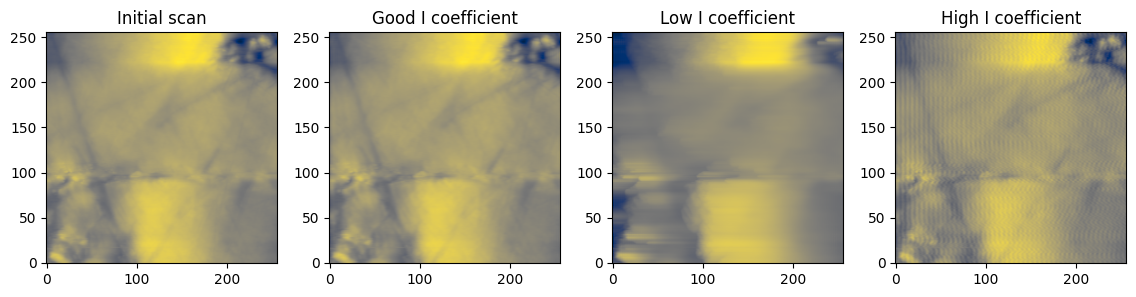

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(14,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Initial scan')
ax[1].imshow(dat_norm[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Good I coefficient')
ax[2].imshow(dat_low[0].T, cmap='cividis', origin='lower')
ax[2].set_title('Low I coefficient')
ax[3].imshow(dat_high[0].T, cmap='cividis', origin='lower')
ax[3].set_title('High I coefficient')

Let's compare our different cases with the good coefficient.

When the I coefficient is **low**, the features are blurry and not sharp. When the I coefficient is **high**, we see vertical lines on the image, even though the features of sharp. This is noise generated due to high value of I.

### Effect of the scan direction and trace

In SPM, users can typically specify the **scan direction**—either vertical or horizontal—and set the **trace parameter** to determine the scan's trajectory, either **forward** (left to right) or **backward** (right to left). These settings significantly impact the observed scan results, particularly in cases with imperfect PID settings.


In [10]:
#scan with too low I coef.
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_low_I},]
array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',],
                                                 modification=mod_dict,
                                                 trace='forward',
                                                 direction='horizontal')
dat_low_hf =  np.array(array_list, dtype=dtype).reshape(shape)

array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',],
                                                 modification=mod_dict,
                                                 trace='backward',
                                                 direction='horizontal')
dat_low_hb =  np.array(array_list, dtype=dtype).reshape(shape)

array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',],
                                                 modification=mod_dict,
                                                 trace='forward',
                                                 direction='vertical')
dat_low_vf =  np.array(array_list, dtype=dtype).reshape(shape)

array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace',],
                                                 modification=mod_dict,
                                                 trace='backward',
                                                 direction='vertical')
dat_low_vb =  np.array(array_list, dtype=dtype).reshape(shape)

Text(0.5, 1.0, 'Low I, vert.-backw.')

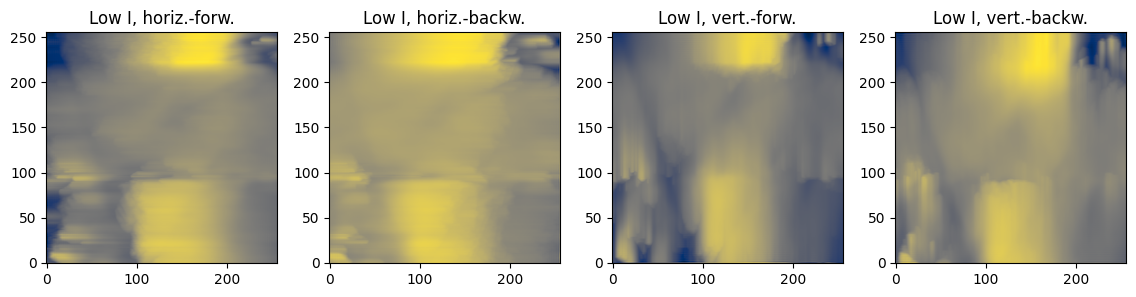

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(14,3))

ax[0].imshow(dat_low_hf[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Low I, horiz.-forw.')
ax[1].imshow(dat_low_hb[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Low I, horiz.-backw.')
ax[2].imshow(dat_low_vf[0].T, cmap='cividis', origin='lower')
ax[2].set_title('Low I, vert.-forw.')
ax[3].imshow(dat_low_vb[0].T, cmap='cividis', origin='lower')
ax[3].set_title('Low I, vert.-backw.')

### Single-line with PID

In [12]:
array_list, shape, dtype  =  mic_server.scan_individual_line('vertical',
                                                             channels=['HeightRetrace'],
                                                             coord = -1e-6,
                                                             modification=None,
                                                             trace='forward')
line = np.array(array_list, dtype=dtype).reshape(shape)

#low I
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_low_I},]
array_list, shape, dtype  =  mic_server.scan_individual_line('vertical',
                                                             channels=['HeightRetrace'],
                                                             coord = -1e-6,
                                                             modification=mod_dict,
                                                             trace='forward')
line1 = np.array(array_list, dtype=dtype).reshape(shape)

#high I
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_high_I},]
array_list, shape, dtype  =  mic_server.scan_individual_line('vertical',
                                                             channels=['HeightRetrace'],
                                                             coord = -1e-6,
                                                             modification=mod_dict,
                                                             trace='forward')
line2 = np.array(array_list, dtype=dtype).reshape(shape)

#normal I
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_normal_I},]
array_list, shape, dtype  =  mic_server.scan_individual_line('vertical',
                                                             channels=['HeightRetrace'],
                                                             coord = -1e-6,
                                                             modification=mod_dict,
                                                             trace='forward')
line3 = np.array(array_list, dtype=dtype).reshape(shape)

line1.shape

(1, 256)

Text(0.5, 1.0, 'High I coefficient')

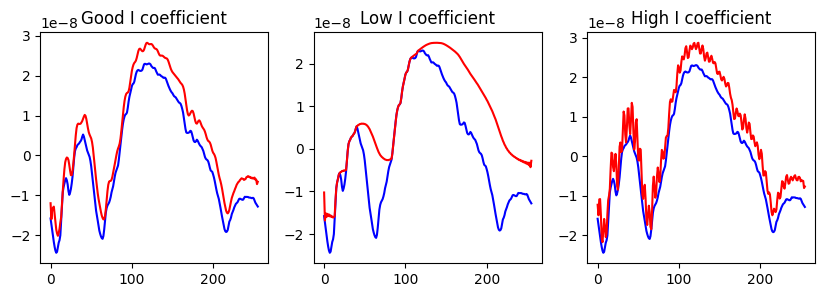

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))


ax[0].plot(line[0], color='b')
ax[0].plot(line3[0], color='r')
ax[0].set_title('Good I coefficient')

ax[1].plot(line[0], color='b')
ax[1].plot(line1[0], color='r')
ax[1].set_title('Low I coefficient')

ax[2].plot(line[0], color='b')
ax[2].plot(line2[0], color='r')
ax[2].set_title('High I coefficient')

When we have a decent enough I coefficient, the trace and retrace curves almost overlap or atleast have the exact same shape.

When we have a low I value, the red curve totally missed the features in the ground truth (blue curve) and hence we get blurry images.

When the I value is high, the retrace captures all the major features in the ground truth, but tries to overfit for the small fluctuations, creating unnecessary noise( the vertical lines in the image )

## Contact vs Tapping mode

There are two ways the probe interacts with the material surface. They are called tapping mode and contact mode. As the name suggests, contact mode runs with the probe touching the surface. Hence to simulate contact mode, put dz = 0. Any other value above zero simulates tapping mode. By default, let's have dz = 5e-9 for tapping mode

In [14]:
kwargs_contact = {'I': 30, 'dz':0, 'sample_rate': 2000}
kwargs_tapping = {'I': 15, 'dz':5e-9, 'sample_rate': 2000}

In [21]:
line =  mic_server.scan_individual_line('vertical', channels=['HeightRetrace'], coord = -1e-6, modification=None)
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_contact},]
line1 =  mic_server.scan_individual_line('vertical', channels=['HeightRetrace'],coord = -1e-6, modification=mod_dict)
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_tapping},]
line2 =  mic_server.scan_individual_line('vertical', channels=['HeightRetrace'],coord = -1e-6, modification=mod_dict)

Text(0.5, 1.0, 'Tapping Mode')

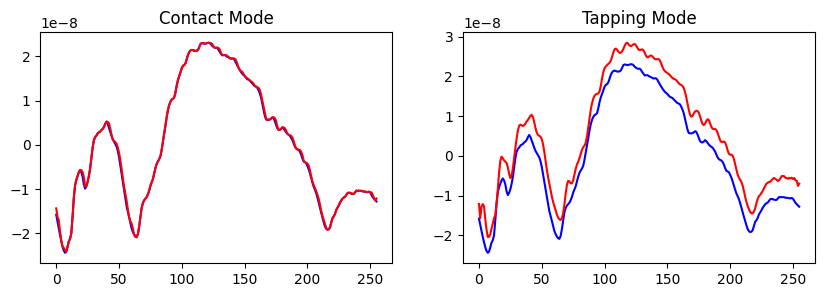

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))


ax[0].plot(line[0][0], color='b')
ax[0].plot(line1[0][0], color='r')
ax[0].set_title('Contact Mode')

ax[1].plot(line[0][0], color='b')
ax[1].plot(line2[0][0], color='r')
ax[1].set_title('Tapping Mode')
